##### Feature Selection
Perform feature selection using the Catboost regressor on scaled data

In [1]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [2]:
# Modelling imports
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
import warnings

In [3]:
scaled_X_train=pd.read_csv('data/scaled_X_train.csv')
scaled_y_train=pd.read_csv('data/scaled_y_train.csv')
scaled_X_test=pd.read_csv('data/scaled_X_test.csv')
scaled_y_test=pd.read_csv('data/scaled_y_test.csv')

In [4]:
scaled_X_train.shape

(8360, 26)

In [5]:
scaled_X_test.shape

(2090, 26)

Define code to calculate adjusted r2 score which is important for comparing models with different number of features

In [6]:
def adjusted_r2_score(y_true, y_pred, X_features):
    """
    Calculates the adjusted R-squared score.

    Args:
        y_true (array-like): True values of the dependent variable.
        y_pred (array-like): Predicted values of the dependent variable.
        X_features (DataFrame or ndarray): The matrix of independent variables (features).

    Returns:
        float: The adjusted R-squared score.
    """
    r2 = r2_score(y_true, y_pred)
    n = len(y_true)  # Number of observations
    p = X_features.shape[1]  # Number of features (independent variables)
    adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))
    return adj_r2

In [7]:
# define evaluate models function
# calculates mean absolute error, mean squared error, root mean squared error
# and r2 score
def evaluate_model(true, predicted, X_features):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    mape = mean_absolute_percentage_error(true, predicted)
    r2_square = r2_score(true, predicted)
    adj_r2 = adjusted_r2_score(true, predicted, X_features)
    return mae, mse, rmse, mape, r2_square, adj_r2

Define catboost regressor as baseline and run it

In [8]:
models = {
      "CatBoosting Regressor": CatBoostRegressor(verbose=False, random_state=42)
}
# define empty list
model_list = []
r2_list =[]

# for every model in the list
for i in range(len(list(models))):
    # set model to model at index i
    model = list(models.values())[i]

   # Train model
    model.fit(scaled_X_train, scaled_y_train) 

    # Make predictions
    y_train_pred = model.predict(scaled_X_train)
    y_test_pred = model.predict(scaled_X_test)
    
    # Evaluate Train and Test dataset
    # y_train is actual value, y_train_pred is predicted values from X_train
    model_train_mae, model_train_mse, model_train_rmse, model_train_mape, model_train_r2, model_train_adj_r2 = evaluate_model(scaled_y_train, y_train_pred, scaled_X_train)
    # y_test is actual value, y_test_pred is predicted value from X_test
    model_test_mae, model_test_mse, model_test_rmse, model_test_mape, model_test_r2, model_test_adj_r2 = evaluate_model(scaled_y_test, y_test_pred, scaled_X_test)

    
    print(list(models.keys())[i])

    # append each model to model_list
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Squared Error: {:.4f}".format(model_train_mse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print(f"- Mean Absolute Percentage Error: {model_train_mape * 100:.4f}%")
    print("- R2 Score: {:.4f}".format(model_train_r2))
    print("- Adjusted R2 Score: {:.4f}".format(model_train_adj_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Squared Error: {:.4f}".format(model_test_mse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print(f"- Mean Absolute Percentage Error: {model_test_mape * 100:.4f}%")
    print("- R2 Score: {:.4f}".format(model_test_r2))
    print("- Adjusted R2 Score: {:.4f}".format(model_test_adj_r2))
    r2_list.append(model_test_r2)

    print('='*35)
    print('\n')

    # Extract feature importances from Gradient Boosting Classifier
    importances = model.feature_importances_
    feature_names = scaled_X_train.columns
    feature_importances = pd.Series(importances, index=feature_names)

    # sort feature importances and names
    feature_importances_sorted = feature_importances.sort_values(ascending=False)
    feature_names_sorted = feature_importances_sorted.index

    print(feature_importances_sorted)

CatBoosting Regressor
Model performance for Training set
- Root Mean Squared Error: 0.1339
- Mean Squared Error: 0.0179
- Mean Absolute Error: 0.0971
- Mean Absolute Percentage Error: 1.0787%
- R2 Score: 0.9312
- Adjusted R2 Score: 0.9310
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 0.1521
- Mean Squared Error: 0.0231
- Mean Absolute Error: 0.1120
- Mean Absolute Percentage Error: 1.2427%
- R2 Score: 0.9130
- Adjusted R2 Score: 0.9120


dept_month           15.664665
Route2               14.781876
dept_day             12.480434
Jet Airways           7.604297
Total_Stops           7.223176
Route3                7.023193
IndiGo                4.049747
dept_hour             3.637981
duration_hours        2.720316
SpiceJet              2.564981
dept_minute           2.557153
Route1                2.494068
arrival_hour          2.426210
S_Mumbai              2.220372
Route4                1.633016
Multiple carriers     1.578203
arrival_minute 

Observation: highest feature importance with:
lowest with:
This would fit what i expect

##### Try iterative feature removal

In [9]:
def iterative_feature_removal(X_train, y_train, X_test, y_test, feature_importance_sorted):
    """
    Iteratively remove 2 least important features and retrain Catboost model until 0 features.
    
    Parameters:
    -----------
    X_train, y_train : Training data and target
    X_test, y_test : Test data and target
    feature_importance_sorted : DataFrame with features sorted by importance (most to least)
    
    Returns:
    --------
    results_df : DataFrame with model performance metrics at each iteration
    """
    
    # Initialize results list
    results = []
    
    # Get list of features from most to least important
    features_list = feature_importance_sorted.index.tolist()  # or feature_importance_sorted['feature'].tolist() depending on your df structure
    
    # Start with all features
    current_features = features_list.copy()
    
    iteration = 0
    while len(current_features) > 0:
        print(f"\n{'='*50}")
        print(f"Iteration {iteration + 1}: Training with {len(current_features)} features")
        print(f"{'='*50}")
        
        # Select current features for training and testing
        X_train_subset = X_train[current_features]
        X_test_subset = X_test[current_features]
        
        # Train model
        model = CatBoostRegressor(verbose=False, random_state=42)
        model.fit(X_train_subset, y_train)
        
        # Get predictions
        y_train_pred = model.predict(X_train_subset)
        y_test_pred = model.predict(X_test_subset)

        # Evaluate Train and Test dataset
        # y_train is actual value, y_train_pred is predicted values from X_train
        model_train_mae, model_train_mse, model_train_rmse, model_train_mape, model_train_r2, model_train_adj_r2 = evaluate_model(scaled_y_train, y_train_pred, X_train_subset)
        # y_test is actual value, y_test_pred is predicted value from X_test
        model_test_mae, model_test_mse, model_test_rmse, model_test_mape, model_test_r2, model_test_adj_r2 = evaluate_model(scaled_y_test, y_test_pred, X_test_subset)
        
        # Store results
        results.append({
            'num_of_features': len(current_features),
            'training_r2': model_train_r2,
            'training_adj_r2': model_train_adj_r2,
            'training_mae': model_train_mae,
            'training_mse': model_train_mse,
            'training_rmse': model_train_rmse,
            'training_mape': model_train_mape,
            'test_r2': model_test_r2,
            'test_adj_r2': model_test_adj_r2,
            'test_mae': model_test_mae,
            'test_mse': model_test_mse,
            'test_rmse': model_test_rmse,
            'test_mape': model_test_mape,
        })
        
        # Print current results
        print(f"Training R2: {model_train_r2:.4f}")
        print(f"Training Adj R2: {model_train_adj_r2:.4f}")
        print(f"Test MAE: {model_test_mae:.4f}")
        print(f"Test RMSE: {model_test_rmse:.4f}")
        print(f"Test R2: {model_test_r2:.4f}")
        print(f"Test Adj R2: {model_test_adj_r2:.4f}")
        
        # Remove 2 least important features for next iteration
        if len(current_features) > 2:
            current_features = current_features[:-2]  # Remove last 2 features (least important)
        elif len(current_features) == 2:
            current_features = current_features[:-2]  # Remove both remaining features
        else:
            current_features = []  # Remove the last feature
        
        iteration += 1
    
    # Create DataFrame from results
    results_df = pd.DataFrame(results)
    
    # Reorder columns
    results_df = results_df[['num_of_features', 'training_r2', 'training_adj_r2', 'test_r2', 'test_adj_r2', 'training_mae', 'training_mse', 'training_rmse', 'training_mape', 'test_mae', 'test_mse', 'test_rmse', 'test_mape']]
    
    return results_df

In [10]:
results_df = iterative_feature_removal(scaled_X_train, scaled_y_train, scaled_X_test, scaled_y_test, feature_importances_sorted)

# Display results
print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)
print(results_df.to_string(index=False))


Iteration 1: Training with 26 features
Training R2: 0.9312
Training Adj R2: 0.9310
Test MAE: 0.1119
Test RMSE: 0.1524
Test R2: 0.9128
Test Adj R2: 0.9117

Iteration 2: Training with 24 features
Training R2: 0.9307
Training Adj R2: 0.9305
Test MAE: 0.1126
Test RMSE: 0.1530
Test R2: 0.9120
Test Adj R2: 0.9110

Iteration 3: Training with 22 features
Training R2: 0.9295
Training Adj R2: 0.9293
Test MAE: 0.1153
Test RMSE: 0.1549
Test R2: 0.9099
Test Adj R2: 0.9089

Iteration 4: Training with 20 features
Training R2: 0.9293
Training Adj R2: 0.9291
Test MAE: 0.1155
Test RMSE: 0.1549
Test R2: 0.9099
Test Adj R2: 0.9090

Iteration 5: Training with 18 features
Training R2: 0.9293
Training Adj R2: 0.9291
Test MAE: 0.1154
Test RMSE: 0.1555
Test R2: 0.9091
Test Adj R2: 0.9083

Iteration 6: Training with 16 features
Training R2: 0.9259
Training Adj R2: 0.9258
Test MAE: 0.1172
Test RMSE: 0.1567
Test R2: 0.9078
Test Adj R2: 0.9071

Iteration 7: Training with 14 features
Training R2: 0.9224
Training A

You can see the R2 is still very good all through 12 features

Define and run fucntion to do recursive feature elimination with cross validatio nto determine optimal features

In [11]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

def rfecv_feature_selection(X_train, y_train, X_test, y_test):
    """
    Perform Recursive Feature Elimination with Cross-Validation (RFECV) on CatBoost model.
    
    Parameters:
    -----------
    X_train, y_train : Training data and labels
    X_test, y_test : Test data and labels
    
    Returns:
    --------
    rfecv : Fitted RFECV object
    results_df : DataFrame with performance metrics using selected features
    """
    
    print("="*80)
    print("RECURSIVE FEATURE ELIMINATION WITH CROSS-VALIDATION (RFECV)")
    print("="*80)
    
    # Initialize the model
    catboost_model = CatBoostRegressor(random_state=42, verbose=0)
    
    # Initialize RFECV with 5-fold cross-validation
    # Using KFold for regression (not StratifiedKFold which is for classification)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    
    rfecv = RFECV(
        estimator=catboost_model,
        step=1,  # Remove 1 feature at each iteration
        cv=cv,
        scoring='neg_mean_squared_error',  # Common regression metrics: 'neg_mean_squared_error', 'r2', 'neg_mean_absolute_error'
        min_features_to_select=1,
        n_jobs=-1  # Use all available cores
    )
    
    print("\nFitting RFECV")
    print(f"Starting with {X_train.shape[1]} features\n")
    
    # Fit RFECV
    rfecv.fit(X_train, y_train)
    
    # Print results
    print(f"\nOptimal number of features: {rfecv.n_features_}")
    print(f"Features removed: {X_train.shape[1] - rfecv.n_features_}")
    
    # Get selected feature names
    selected_features = X_train.columns[rfecv.support_].tolist()
    print(f"\nSelected features ({len(selected_features)}):")
    for i, feat in enumerate(selected_features, 1):
        print(f"  {i}. {feat}")
    
    # Get eliminated feature names
    eliminated_features = X_train.columns[~rfecv.support_].tolist()
    if eliminated_features:
        print(f"\nEliminated features ({len(eliminated_features)}):")
        for i, feat in enumerate(eliminated_features, 1):
            print(f"  {i}. {feat}")
    
    # Transform training and test sets to use only selected features
    X_train_selected = rfecv.transform(X_train)
    X_test_selected = rfecv.transform(X_test)
    
    print("\n" + "="*80)
    print("MODEL PERFORMANCE WITH SELECTED FEATURES")
    print("="*80)
    
    # Train final model with selected features
    final_model = CatBoostRegressor(random_state=42, verbose=0)
    final_model.fit(X_train_selected, y_train)
    
    # Get predictions
    y_train_pred = final_model.predict(X_train_selected)
    y_test_pred = final_model.predict(X_test_selected)
    
    # Evaluate Train and Test dataset
    # y_train is actual value, y_train_pred is predicted values from X_train
    model_train_mae, model_train_mse, model_train_rmse, model_train_mape, model_train_r2, model_train_adj_r2 = evaluate_model(y_train, y_train_pred, X_train_selected)
    # y_test is actual value, y_test_pred is predicted value from X_test
    model_test_mae, model_test_mse, model_test_rmse, model_test_mape, model_test_r2, model_test_adj_r2 = evaluate_model(y_test, y_test_pred, X_test_selected)
    
    # Create results dictionary
    results = {
        'num_of_features': rfecv.n_features_,
        'train_mse': model_train_mse,
        'train_rmse': model_train_rmse,
        'train_mae': model_train_mae,
        'train_mape': model_train_mape,
        'train_r2': model_train_r2,
        'train_adj_r2': model_train_adj_r2,
        'test_mse': model_test_mse,
        'test_rmse': model_test_rmse,
        'test_mae': model_test_mae,
        'test_mape': model_test_mape,
        'test_r2': model_test_r2,
        'test_adj_r2': model_test_adj_r2,
    }
    
    # Print results
    print(f"\nNumber of Features: {results['num_of_features']}")
    print(f"\nTraining Metrics:")
    print(f"  MSE: {model_train_mse:.4f}")
    print(f"  RMSE: {model_train_rmse:.4f}")
    print(f"  MAE: {model_train_mae:.4f}")
    print(f"  MAPE: {model_train_mape * 100:.2f}%")
    print(f"  R2: {model_train_r2:.4f}")
    print(f"  Adjusted R2: {model_train_adj_r2:.4f}")
    print(f"\nTest Metrics:")
    print(f"  MSE: {model_test_mse:.4f}")
    print(f"  RMSE: {model_test_rmse:.4f}")
    print(f"  MAE: {model_test_mae:.4f}")
    print(f"  MAPE: {model_test_mape * 100:.2f}%")
    print(f"  R2: {model_test_r2:.4f}")
    print(f"  Adjusted R2: {model_test_adj_r2:.4f}")
    
    # Create DataFrame
    results_df = pd.DataFrame([results])
    
    # Plot cross-validation scores
    plt.figure(figsize=(12, 6))
    # Note: For neg_mean_squared_error, scores are negative, so we negate them for visualization
    cv_scores = -rfecv.cv_results_['mean_test_score'] if 'neg_' in 'neg_mean_squared_error' else rfecv.cv_results_['mean_test_score']
    plt.plot(range(1, len(cv_scores) + 1), 
             cv_scores, 
             marker='o', linewidth=2, markersize=6)
    plt.xlabel('Number of Features Selected', fontsize=12)
    plt.ylabel('Cross-Validation Score (MSE)', fontsize=12)
    plt.title('RFECV: Feature Selection Performance', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.axvline(x=rfecv.n_features_, color='r', linestyle='--', 
                label=f'Optimal: {rfecv.n_features_} features', linewidth=2)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.show()
    
    # Create feature ranking DataFrame
    feature_ranking_df = pd.DataFrame({
        'Feature': X_train.columns,
        'Ranking': rfecv.ranking_,
        'Selected': rfecv.support_
    }).sort_values('Ranking')
    
    print("\n" + "="*80)
    print("FEATURE RANKING")
    print("="*80)
    print(feature_ranking_df.to_string(index=False))
    
    return rfecv, results_df, selected_features, feature_ranking_df

RECURSIVE FEATURE ELIMINATION WITH CROSS-VALIDATION (RFECV)

Fitting RFECV
Starting with 26 features


Optimal number of features: 25
Features removed: 1

Selected features (25):
  1. Total_Stops
  2. dept_day
  3. dept_month
  4. dept_hour
  5. dept_minute
  6. arrival_hour
  7. arrival_minute
  8. duration_hours
  9. duration_minutes
  10. Route1
  11. Route2
  12. Route3
  13. Route4
  14. Air India
  15. GoAir
  16. IndiGo
  17. Jet Airways
  18. Multiple carriers
  19. SpiceJet
  20. Vistara
  21. S_Delhi
  22. S_Kolkata
  23. S_Mumbai
  24. D_Delhi
  25. D_New Delhi

Eliminated features (1):
  1. S_Chennai

MODEL PERFORMANCE WITH SELECTED FEATURES

Number of Features: 25

Training Metrics:
  MSE: 0.0180
  RMSE: 0.1340
  MAE: 0.0973
  MAPE: 1.08%
  R2: 0.9311
  Adjusted R2: 0.9309

Test Metrics:
  MSE: 0.0235
  RMSE: 0.1533
  MAE: 0.1130
  MAPE: 1.25%
  R2: 0.9117
  Adjusted R2: 0.9106


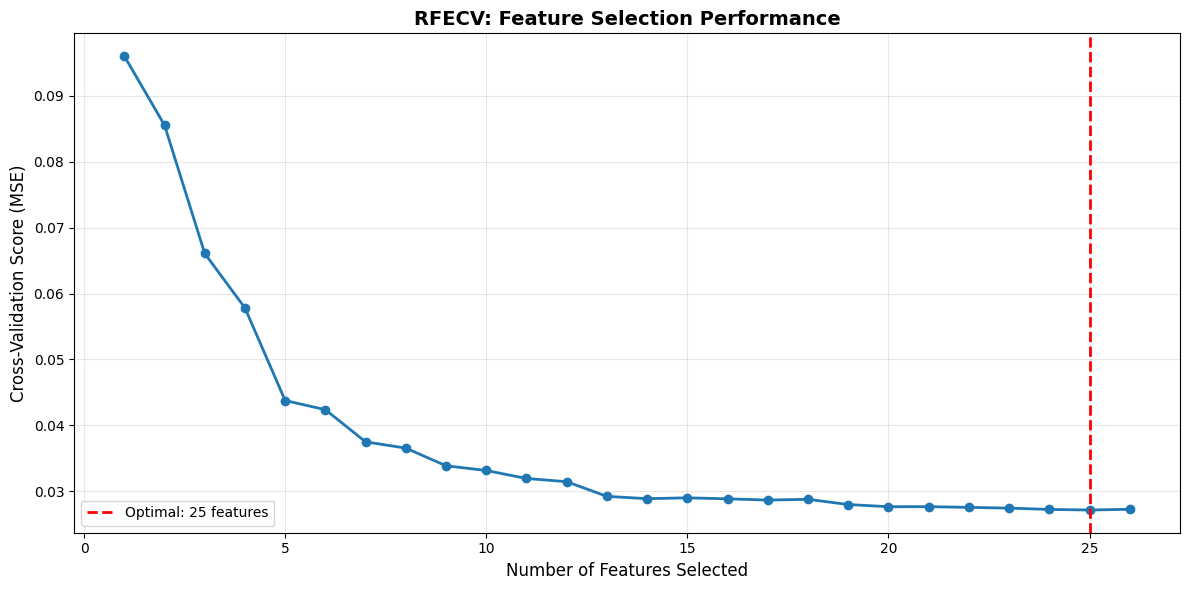


FEATURE RANKING
          Feature  Ranking  Selected
      Total_Stops        1      True
         dept_day        1      True
       dept_month        1      True
        dept_hour        1      True
      dept_minute        1      True
     arrival_hour        1      True
   arrival_minute        1      True
   duration_hours        1      True
 duration_minutes        1      True
           Route1        1      True
           Route2        1      True
           Route3        1      True
           Route4        1      True
        Air India        1      True
            GoAir        1      True
           IndiGo        1      True
      Jet Airways        1      True
Multiple carriers        1      True
         SpiceJet        1      True
          Vistara        1      True
          S_Delhi        1      True
        S_Kolkata        1      True
         S_Mumbai        1      True
          D_Delhi        1      True
      D_New Delhi        1      True
        S_Chennai    

In [12]:
# Run RFECV
rfecv_model, rfecv_results, selected_features, feature_ranking = rfecv_feature_selection(
    scaled_X_train, scaled_y_train, scaled_X_test, scaled_y_test
)

# Display final results
print("\n" + "="*80)
print("RFECV FINAL RESULTS")
print("="*80)
print(rfecv_results.to_string(index=False))

# Access the transformed datasets if needed
X_train_rfecv = rfecv_model.transform(scaled_X_train)
X_test_rfecv = rfecv_model.transform(scaled_X_test)

print(f"\nOriginal shape: {scaled_X_train.shape}")
print(f"Transformed shape: {X_train_rfecv.shape}")

Observation: 1 feature remove for optimal model.
Has lowest mutual info score

Remove this feature from X_trian and test

In [13]:
final_scaled_X_train = scaled_X_train.drop(['S_Chennai'], axis=1)
final_scaled_X_test = scaled_X_test.drop(['S_Chennai'], axis=1)

In [14]:
final_scaled_X_train.shape, final_scaled_X_test.shape

((8360, 25), (2090, 25))

In [15]:
final_scaled_X_train.to_csv("data/final_scaled_X_train.csv", index=False)
final_scaled_X_test.to_csv("data/final_scaled_X_test.csv", index=False)